In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/BSNIP'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['Age_cal'].keys()))
print(len(subs))

1244


In [2]:
import numpy as np

task = 'unk'
x = []
y = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['SZP']:
        continue
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    x.append(p)
    y.append(demo['DXGROUP_1'][sub] == 'SZP')
#     y.append(int(demo['Age_cal'][sub]))
#     y.append(demo['sex'][sub] == 'M')
    
x = np.stack(x)
y = np.array(y).astype('int')

print(x.shape)
print(y.shape)
print(y[0:5])

(199, 34716)
(199,)
[1 1 1 1 1]


In [3]:
import torch

xtr = torch.from_numpy(x).float().cuda()

d = torch.cdist(xtr, xtr)

print(d.shape)

torch.Size([199, 199])


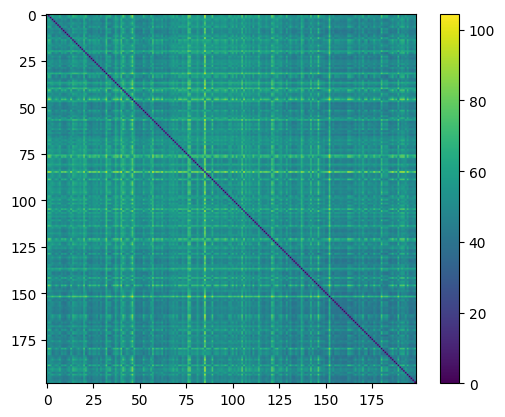

In [4]:
import matplotlib.pyplot as plt

plt.imshow(d.detach().cpu().numpy())
plt.colorbar()
plt.show()

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init='auto').fit(x)
print(kmeans.labels_)

idcs = np.where(kmeans.labels_ == 0)[0]
sz1 = x[idcs]

idcs = np.where(kmeans.labels_ == 1)[0]
sz2 = x[idcs]

[0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0
 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1
 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0]


In [14]:
print(len(sz1))
print(len(sz2))

1
137


In [6]:
idcs

array([  0,   3,   4,   6,   7,  11,  12,  14,  15,  16,  18,  19,  21,
        27,  29,  33,  34,  41,  42,  45,  46,  52,  53,  54,  56,  63,
        66,  68,  70,  76,  77,  85,  89,  98,  99, 101, 103, 105, 107,
       109, 110, 112, 113, 114, 121, 122, 125, 126, 127, 129, 136, 139,
       140, 142, 144, 145, 146, 147, 154, 166, 169, 170, 173, 180, 181,
       182, 183, 189, 193])

In [8]:
demo['sz_subtype'] = dict()

i = 0

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['SZP']:
        continue
    if i in idcs:
        demo['sz_subtype'][sub] = '2'
    else:
        demo['sz_subtype'][sub] = '1'
    i += 1
        
pickle.dump(demo, open(demoname, 'wb'))
print('Complete')

Complete


In [6]:
task = 'unk'
nc = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['NC']:
        continue
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    nc.append(p)
    
nc = np.stack(nc)

print(nc.shape)

(242, 34716)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

accs = []

for _ in range(20):
    np.random.shuffle(nc)
    sz = np.concatenate([sz1])
    np.random.shuffle(sz)

    x = np.concatenate([sz[:69], nc[:69]])
    y = np.concatenate([np.ones(69), np.zeros(69)]).astype('int')
    
    xtr, xt, ytr, yt = train_test_split(x, y, stratify=y, train_size=0.8)
    print('Done split')
    
    clf = LogisticRegression(max_iter=1000).fit(xtr, ytr)
    yhat = clf.predict(xt)
    acc = np.mean(yhat == yt)
    print(acc)
    accs.append(acc)
    
print('---')
print(np.mean(accs))
print(np.std(accs))

Done split
0.8214285714285714
Done split
0.9285714285714286
Done split
0.9285714285714286
Done split
0.7857142857142857
Done split
0.7142857142857143
Done split
0.75
Done split
0.8214285714285714
Done split
0.8571428571428571
Done split
0.7857142857142857
Done split
0.75
Done split
0.8571428571428571
Done split
0.7142857142857143
Done split
0.8571428571428571
Done split
0.8214285714285714
Done split
0.7857142857142857
Done split
0.7142857142857143
Done split
0.8214285714285714
Done split
0.8571428571428571
Done split
0.7857142857142857
Done split
0.75
---
0.8053571428571429
0.062346750893200326


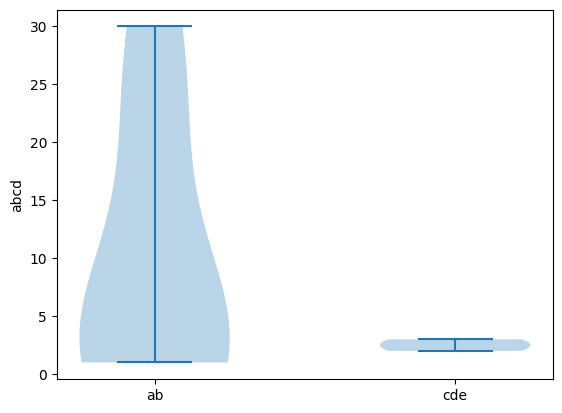

In [16]:
# Debugging stupid violinplot

import matplotlib.pyplot as plt

data = [np.array([1,2,3,20,30,4]),np.array([2,3])]

fig, ax = plt.subplots()
ax.violinplot(data, positions=[1,2])
ax.set_xticks([1,2])
ax.set_xticklabels(['ab','cde'])
ax.set_ylabel('abcd')
fig.show()